In [1]:
import sys
print(sys.executable)


c:\Users\smanasi\AppData\Local\miniconda3\envs\mammal\envs\mammal310\python.exe


In [9]:
import numpy as np
import pandas as pd

df = pd.read_csv("../data/sim_dataTL/sim_magnav_with_lines.csv")
print(df.columns)
print("rows:", len(df))
print("num lines:", df["line"].nunique() if "line" in df else df["line_id"].nunique())
df.head()


Index(['time_s', 'lat', 'lon', 'alt_m', 'mag_scalar_nT',
       'mag_anomaly_injected_nT', 'mag_residual_nT', 'heading_deg',
       'turn_score_deg', 'is_turn', 'LINE', 'east_m', 'north_m', 'line'],
      dtype='object')
rows: 148016
num lines: 18


,time_s,lat,lon,alt_m,mag_scalar_nT,mag_anomaly_injected_nT,mag_residual_nT,heading_deg,turn_score_deg,is_turn,LINE,east_m,north_m,line
0,0.00,-27.116237,131.084472,100.0,55445.483869,-6.953404,35.695884,0.0,0.0,False,0,-0.000000e+00,0.0,0
1,0.01,-27.116235,131.084472,100.0,55382.321804,-6.683435,-27.465100,0.0,0.0,False,0,-4.430909e-10,0.2,0
2,0.02,-27.116233,131.084472,100.0,55415.597191,-6.412450,5.811368,0.0,0.0,False,0,-6.338969e-10,0.4,0
3,0.03,-27.116232,131.084472,100.0,55378.849986,-6.140469,-30.934757,0.0,0.0,False,0,-2.214297e-10,0.6,0
4,0.04,-27.116230,131.084472,100.0,55332.821138,-5.867511,-76.962524,0.0,0.0,False,0,-2.586540e-10,0.8,0


In [11]:
import MAMMAL, pkgutil
mods = [m.name for m in pkgutil.walk_packages(MAMMAL.__path__, MAMMAL.__name__ + ".")]
[x for x in mods if "pca" in x.lower() or "tie" in x.lower() or "lvl" in x.lower()]


['MAMMAL.MapLvl', 'MAMMAL.MapLvl.pcaLvl', 'MAMMAL.MapLvl.tieLvl']

In [12]:
from MAMMAL.MapLvl import pcaLvl, tieLvl


for tie levelling we need
tie_lvl.py needs a dataframe with (at minimum):

LAT, LONG, F

LINE (integer line id)

LINE_TYPE (1 = flight line, 2 = tie line)

GET MEAN HEADING OF EVERY SEGMENT - so we can get the directions of each heading and then classify into tie/flight lines

In [21]:
line_headings = (
    df.groupby("LINE")["heading_deg"]
      .apply(lambda h: np.nanmedian(h))
      .reset_index()
      .rename(columns={"heading_deg": "mean_heading"})
)

line_headings.head()
line_headings["heading_mod"] = line_headings["mean_heading"] % 180




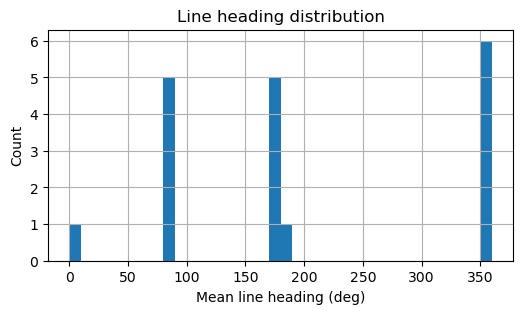

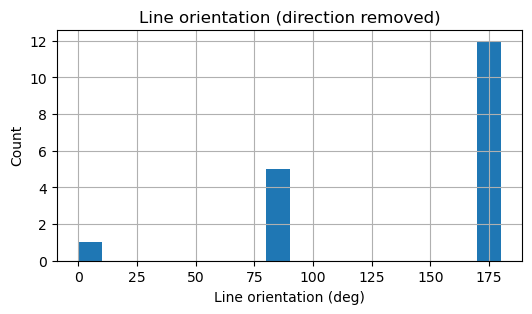

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))
plt.hist(line_headings["mean_heading"], bins=36)
plt.xlabel("Mean line heading (deg)")
plt.ylabel("Count")
plt.title("Line heading distribution")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,3))
plt.hist(line_headings["heading_mod"], bins=18)
plt.xlabel("Line orientation (deg)")
plt.ylabel("Count")
plt.title("Line orientation (direction removed)")
plt.grid(True)
plt.show()


In [27]:
# approximate line length using ENU coords
line_lengths = (
    df.groupby("LINE")
      .apply(lambda g: np.sqrt(
          (g["east_m"].iloc[-1] - g["east_m"].iloc[0])**2 +
          (g["north_m"].iloc[-1] - g["north_m"].iloc[0])**2
      ))
      .reset_index(name="length_m")
)

line_lengths.head()


C:\Users\smanasi\AppData\Local\Temp\ipykernel_20580\1505770814.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.sqrt(


,LINE,length_m
0,0,1999.999901
1,1,1999.999901
2,2,1999.999900
3,3,1999.999899
4,4,1999.999897


In [29]:
line_headings = line_headings.merge(line_lengths, on="LINE")


In [30]:
# take top 30% longest lines
L_thresh = line_headings["length_m"].quantile(0.7)

FL_DIR = (
    line_headings[line_headings["length_m"] >= L_thresh]
    ["heading_mod"]
    .median()
)

FL_DIR


179.99839979877123

In [31]:
def classify_line(h):
    return 1 if abs(h - FL_DIR) < 30 else 2  # 1=FL, 2=TL

line_headings["LINE_TYPE"] = line_headings["heading_mod"].apply(classify_line)


In [33]:
line_headings.groupby("LINE_TYPE")["heading_mod"].describe()


,count,mean,std,min,25%,50%,75%,max
LINE_TYPE,,,,,,,,
1,12.0,179.997028,0.001649,179.994513,179.995771,179.997028,179.998286,179.999543
2,6.0,74.997013,36.740883,0.000000,89.994826,89.996028,89.997505,89.997598


In [35]:
# Merge LINE_TYPE back into the main dataframe using LINE
df = df.merge(
    line_headings[["LINE", "LINE_TYPE"]],
    on="LINE",
    how="left"
)

# Ensure correct dtypes
df["LINE"] = df["LINE"].astype(int)
df["LINE_TYPE"] = df["LINE_TYPE"].astype(int)

df[["time_s", "LINE", "LINE_TYPE"]].head()


,time_s,LINE,LINE_TYPE
0,0.00,0,2
1,0.01,0,2
2,0.02,0,2
3,0.03,0,2
4,0.04,0,2


In [37]:
out_path = "../data/sim_dataTL/sim_magnav_with_lines_and_types.csv"
df.to_csv(out_path, index=False)

print("Saved:", out_path)
print("Columns now include:", df.columns.tolist())
print("Line type counts:")
print(df.groupby("LINE_TYPE")["LINE"].nunique())


Saved: ../data/sim_dataTL/sim_magnav_with_lines_and_types.csv
Columns now include: ['time_s', 'lat', 'lon', 'alt_m', 'mag_scalar_nT', 'mag_anomaly_injected_nT', 'mag_residual_nT', 'heading_deg', 'turn_score_deg', 'is_turn', 'LINE', 'east_m', 'north_m', 'line', 'LINE_TYPE']
Line type counts:
LINE_TYPE
1    12
2     6
Name: LINE, dtype: int64


In [39]:
survey_df = pd.DataFrame({
    "LAT": df["lat"].astype(float),
    "LONG": df["lon"].astype(float),
    "ALT": df["alt_m"].astype(float),
    "F": df["mag_residual_nT"].astype(float),
    "LINE": df["LINE"].astype(int),
    "LINE_TYPE": df["LINE_TYPE"].astype(int),
})

survey_df.head()


,LAT,LONG,ALT,F,LINE,LINE_TYPE
0,-27.116237,131.084472,100.0,35.695884,0,2
1,-27.116235,131.084472,100.0,-27.465100,0,2
2,-27.116233,131.084472,100.0,5.811368,0,2
3,-27.116232,131.084472,100.0,-30.934757,0,2
4,-27.116230,131.084472,100.0,-76.962524,0,2


REMOVE IMU NOISE FIRST. HOW? we combine the trajectory and sim_magnav on time(luckily samping frequency is the same for imu and mag but may not be IRL -> figure out what to do then) -> then have a df with time yaw pitch roll acc and the magnetic values with lat long? (will the lat/lon be different in IRL data - how to decide then)

In [46]:
traj = pd.read_csv("../data/sim_dataTL/trajectory.csv")
mag  = pd.read_csv("../data/sim_dataTL/sim_magnav_with_lines_and_types.csv")

SORT BY TIME 0 needed for merge_asof (can work even on non matching timestamps - simply finds closest - i think)

In [47]:
traj = traj.sort_values("time_s").reset_index(drop=True)
mag  = mag.sort_values("time_s").reset_index(drop=True)


In [48]:
#merge on time using nearest-neighbor alignment
df = pd.merge_asof(
    mag,
    traj,
    on="time_s",
    direction="nearest",
    tolerance=0.05   # seconds — adjust if needed
)


In [50]:
df.isna().sum()
#luckily sim data everything align will probably not IRL

time_s                     0
lat_x                      0
lon_x                      0
alt_m_x                    0
mag_scalar_nT              0
mag_anomaly_injected_nT    0
mag_residual_nT            0
heading_deg                0
turn_score_deg             0
is_turn                    0
LINE                       0
east_m                     0
north_m                    0
line                       0
LINE_TYPE                  0
lat_y                      0
lon_y                      0
alt_m_y                    0
yaw_rad                    0
pitch_rad                  0
roll_rad                   0
dtype: int64

In [51]:
#clean up duplicate coloums - lat lon and alt
# Prefer mag file coordinates (already used for survey)
df = df.drop(columns=["lat_y", "lon_y", "alt_m_y"], errors="ignore")

df = df.rename(columns={
    "lat_x": "lat",
    "lon_x": "lon",
    "alt_m_x": "alt_m"
})


In [52]:
#add degrees versions of IMU angles
df["yaw_deg"]   = np.rad2deg(df["yaw_rad"])
df["pitch_deg"] = np.rad2deg(df["pitch_rad"])
df["roll_deg"]  = np.rad2deg(df["roll_rad"])

In [53]:
df[[
    "time_s",
    "mag_residual_nT",
    "yaw_deg",
    "pitch_deg",
    "roll_deg",
    "LINE",
    "LINE_TYPE"
]].head()


,time_s,mag_residual_nT,yaw_deg,pitch_deg,roll_deg,LINE,LINE_TYPE
0,0.00,35.695884,0.0,0.0,0.0,0,2
1,0.01,-27.465100,0.0,0.0,0.0,0,2
2,0.02,5.811368,0.0,0.0,0.0,0,2
3,0.03,-30.934757,0.0,0.0,0.0,0,2
4,0.04,-76.962524,0.0,0.0,0.0,0,2


NOW WHAT?
1) despike magnetic data
2) remove heaidng-dependent error - nvm don't need this, since there is only 2 directions (4 headings) that plane travels in, this error will simply be removed in the tie-levelling process
3) remove pitch / roll coupling (what is this?)
4) estimate and correct sensor lag
5) global drift removal
6) line detrending
7) tie-line levelling

In [79]:
#using IMU yaw for heading (wrap to 0-360)
# Use yaw from IMU as heading (wrap to 0..360)
df["psi_deg"] = (df["yaw_deg"] % 360.0)
df["psi_rad"] = np.deg2rad(df["psi_deg"])

Classic aircraft/vehicle mag heading error shows up periodic terms as seen in:

e(ψ)=a0​+a1​cosψ+a2​sinψ+a3​cos2ψ+a4​sin2ψ

Can fit this to mag_residual_nT

WHY NOT WORKING?

- maybe instead of f_raw i try fitting to heading-correlated component 
    - HOW? remove mean per heading bin first

In [64]:
F_col = "mag_residual_nT"
df["F_raw"] = df[F_col].astype(float)

F = df["F_raw"].values
baseline = pd.Series(F).rolling(
    501, center=True, min_periods=200
).median().to_numpy()

F_hp = F - baseline

psi = df["psi_rad"].values
X = np.column_stack([
    np.ones_like(psi),
    np.cos(psi),
    np.sin(psi),
    np.cos(2*psi),
    np.sin(2*psi),
])


In [71]:
#train on the 'good' segments - exclude turns cuz turns have dynamic effects, changing fieldsetc)
mask = (~df["is_turn"].astype(bool)) & np.isfinite(F_hp)
coef, *_ = np.linalg.lstsq(X[mask], F_hp[mask], rcond=None)
coef

array([-7.95631591, -0.04466432, 15.47049483,  7.84768194, 30.6992445 ])

In [72]:
#fitting coefficients (simple least square)
# Solve: minimize ||X a - y||^2
#coef, *_ = np.linalg.lstsq(X_train, y_train, rcond=None)

coef_names = ["a0", "a1_cos1", "a2_sin1", "a3_cos2", "a4_sin2"]
pd.Series(coef, index=coef_names)

#a0 = constant offset captured by the model
# sin/cos terms = heading-dependent periodic error

a0         -7.956316
a1_cos1    -0.044664
a2_sin1    15.470495
a3_cos2     7.847682
a4_sin2    30.699245
dtype: float64

In [73]:
#applying the correction
#subtract the estimated heading error, but keep mean level stable
# we want to remove just the heading varying part but not a0, so we don't accidentaly remove the real DC content
y_hat = X @ coef

# Separate constant vs heading-varying component
a0 = coef[0]
heading_error = y_hat - a0  #heaidng component is the heaidng error over time, remove the constant offset a0 from this

df["F_headcorr"] = df["F_raw"] - heading_error


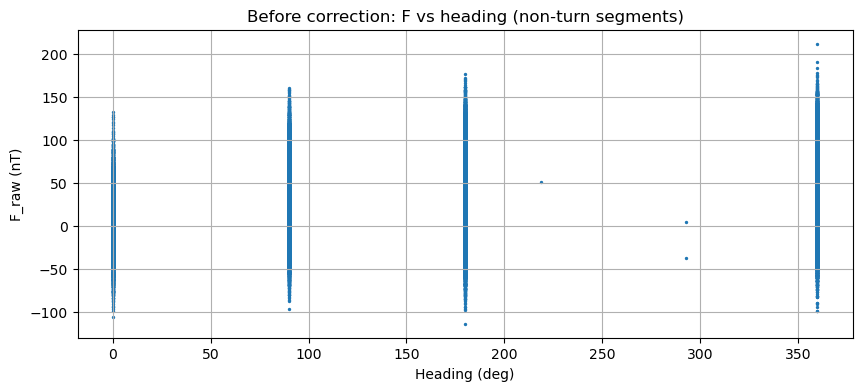

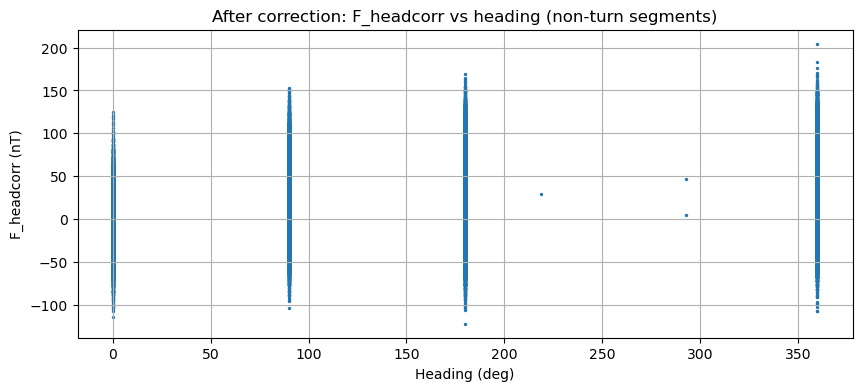

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.scatter(df.loc[train_mask, "psi_deg"], df.loc[train_mask, "F_raw"], s=2)
plt.title("Before correction: F vs heading (non-turn segments)")
plt.xlabel("Heading (deg)")
plt.ylabel("F_raw (nT)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.scatter(df.loc[train_mask, "psi_deg"], df.loc[train_mask, "F_headcorr"], s=2)
plt.title("After correction: F_headcorr vs heading (non-turn segments)")
plt.xlabel("Heading (deg)")
plt.ylabel("F_headcorr (nT)")
plt.grid(True)
plt.show()


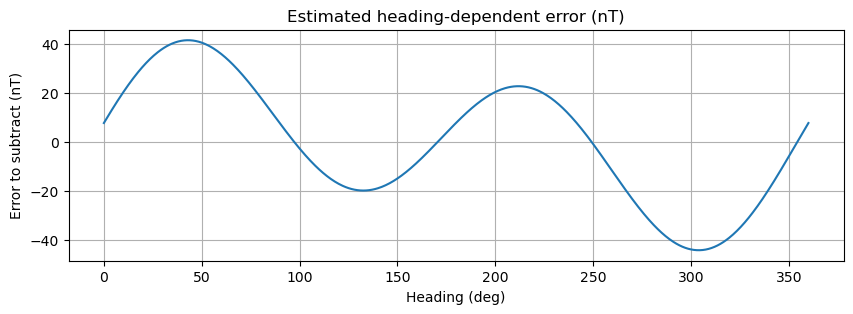

In [75]:
#plot the estimated heading error curve - should look like a smooth periodic function
psi_grid_deg = np.linspace(0, 360, 721)         #plot our the different headings (in deg) and what the heading error will then be
psi_grid = np.deg2rad(psi_grid_deg)

Xg = np.column_stack([
    np.ones_like(psi_grid),
    np.cos(psi_grid),
    np.sin(psi_grid),
    np.cos(2*psi_grid),
    np.sin(2*psi_grid),
])

err_curve = (Xg @ coef) - coef[0]  # heading-only component

plt.figure(figsize=(10,3))
plt.plot(psi_grid_deg, err_curve)
plt.title("Estimated heading-dependent error (nT)")
plt.xlabel("Heading (deg)")
plt.ylabel("Error to subtract (nT)")
plt.grid(True)
plt.show()


#the sample trajectory has no pitch/roll values but the heading error usually changes with tilt (esp if platform is moving)
can add linear pitch/roll coef as well

In [ ]:
'''
#for now don't need, but when new trajectory has pitch/roll as well need to remove heading error due to that as well
p = df["pitch_rad"].values
r = df["roll_rad"].values

X2 = np.column_stack([
    np.ones_like(psi),
    np.cos(psi), np.sin(psi),
    np.cos(2*psi), np.sin(2*psi),
    p, r
])

X2_train = X2[train_mask.values]
coef2, *_ = np.linalg.lstsq(X2_train, y_train, rcond=None)

y_hat2 = X2 @ coef2
heading_component2 = y_hat2 - coef2[0]

df["F_headtilt_corr"] = df["F_raw"] - heading_component2
pd.Series(coef2, index=["a0","c1","s1","c2","s2","bp","br"])
'''

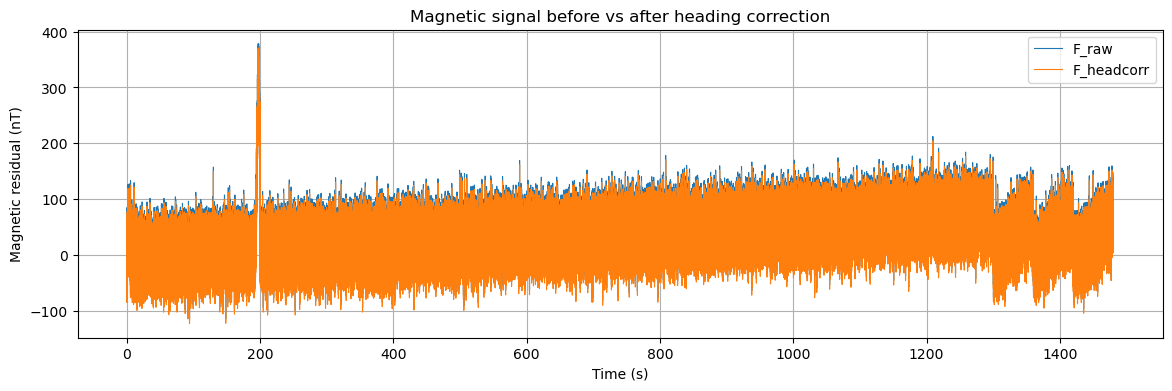

In [76]:
import matplotlib.pyplot as plt
#plotting to see what's gg on
plt.figure(figsize=(14,4))
plt.plot(df["time_s"], df["F_raw"], label="F_raw", linewidth=0.8)
plt.plot(df["time_s"], df["F_headcorr"], label="F_headcorr", linewidth=0.8)
plt.xlabel("Time (s)")
plt.ylabel("Magnetic residual (nT)")
plt.title("Magnetic signal before vs after heading correction")
plt.legend()
plt.grid(True)
plt.show()


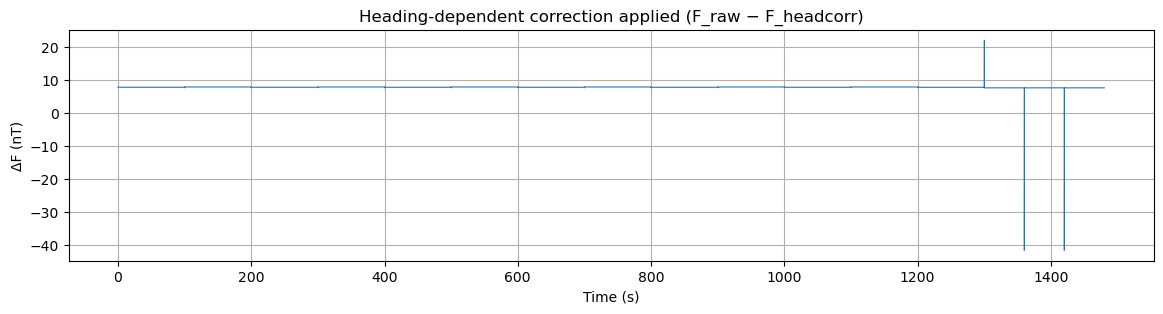

In [77]:
df["delta_F"] = df["F_raw"] - df["F_headcorr"]

plt.figure(figsize=(14,3))
plt.plot(df["time_s"], df["delta_F"], linewidth=0.8)
plt.xlabel("Time (s)")
plt.ylabel("ΔF (nT)")
plt.title("Heading-dependent correction applied (F_raw − F_headcorr)")
plt.grid(True)
plt.show()


IT'S BECAUSE WE DIDNT INJECT HEADING ERROR INTO THE SIM SENSOR READINGS IN THE FIRST PLACE!

In [78]:
#CHECK WHAT headings the drone is flown in
df["psi_deg"].describe(), df["psi_deg"].value_counts().head(10)


(count    148016.000000
 mean        229.849999
 std         117.573034
 min           0.000000
 25%         179.994971
 50%         179.998628
 75%         359.996342
 max         359.999087
 Name: psi_deg, dtype: float64,
 psi_deg
 0.000000      10001
 89.996110         2
 89.998034         2
 89.996681         2
 89.995054         2
 89.997775         2
 90.000000         2
 89.997445         2
 89.995472         2
 179.999543        2
 Name: count, dtype: int64)

Denoising:
1) Savitzky-Golay smoothing - want smooth but still keep peaks/shape
2) median based filter - good to despike
3) low-pass butterworth filter - remove high frequency sensor noise 

In [ ]:
import numpy as np
from scipy.signal import savgol_filter

F = df["F_raw"].to_numpy()
'''
in each window -> fit a low-order polynomial (2/3 degree), evaluate that polynomial at the center.
preserves peak shape, curvature, slopes
removes high-freq noise, but not strong enough for sensor noise
'''
# window length must be odd.
# At 100 Hz: 501 samples = 5.01 s smoothing
win = 501
poly = 3

F_smooth = savgol_filter(F, window_length=win, polyorder=poly)

df["F_smooth_sg"] = F_smooth


In [81]:
from scipy.signal import medfilt

F = df["F_raw"].to_numpy()

# kernel must be odd; 101 at 100 Hz = ~1.01 s
k = 101
F_med = medfilt(F, kernel_size=k)

df["F_smooth_med"] = F_med


You gave:

speed = 20 m/s

sampling = 100 Hz

So:

1 sample = 0.2 m

1 second = 20 m

Spatial meaning of frequency
Frequency	Spatial scale
10 Hz	    2 m
2 Hz	    10 m
1 Hz	    20 m
0.2 Hz	    100 m

In [ ]:
import numpy as np
from scipy.signal import butter, filtfilt

F = df["F_raw"].to_numpy()

fs = 100.0          # sampling rate (Hz) - adjust if different
cutoff = 2.0        # Hz (keep slower-than-2Hz variations)
order = 4

b, a = butter(order, cutoff/(fs/2), btype="low")    #fs/2 = nyquist frequency, choose a cutoff = 1hz
F_lp = filtfilt(b, a, F)

df["F_smooth_lp"] = F_lp


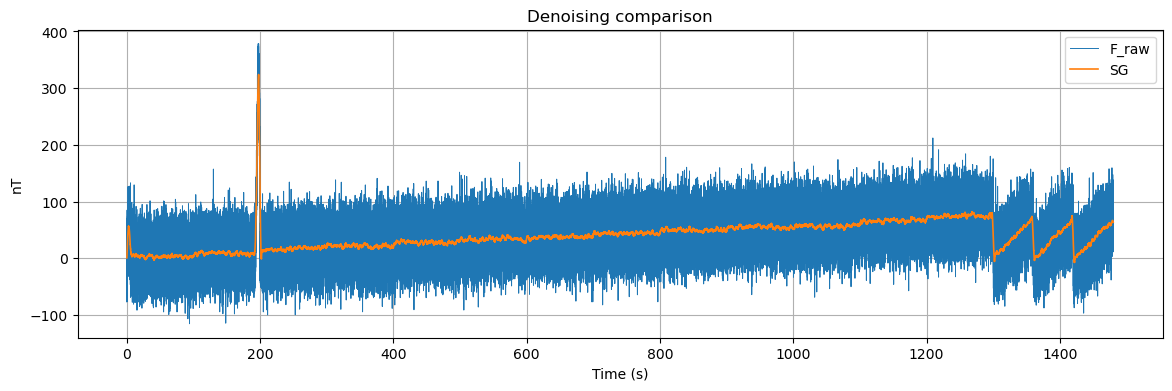

In [86]:
import matplotlib.pyplot as plt

t = df["time_s"]

plt.figure(figsize=(14,4))
plt.plot(t, df["F_raw"], linewidth=0.7, label="F_raw")
if "F_smooth_sg" in df: plt.plot(t, df["F_smooth_sg"], linewidth=1.2, label="SG")
#if "F_smooth_med" in df: plt.plot(t, df["F_smooth_med"], linewidth=1.2, label="Median")
#if "F_smooth_lp" in df: plt.plot(t, df["F_smooth_lp"], linewidth=1.2, label="Low-pass")
plt.legend()
plt.title("Denoising comparison")
plt.xlabel("Time (s)")
plt.ylabel("nT")
plt.grid(True)
plt.show()


In [87]:
# ---- put in the denoised data into a new CSV ----
out_path = "../data/sim_dataTL/sim_magnav_denoised.csv"  # update folder if needed

# Ensure LINE is int
df["LINE"] = df["LINE"].astype(int)

# Add a string line label (some MAMMAL code expects 'line')
df["line"] = df["LINE"].astype(str)

df.to_csv(out_path, index=False)
print("Saved:", out_path)
print("Num lines:", df["LINE"].nunique())
print("Columns now:", df.columns.tolist())

Saved: ../data/sim_dataTL/sim_magnav_denoised.csv
Num lines: 18
Columns now: ['time_s', 'lat', 'lon', 'alt_m', 'mag_scalar_nT', 'mag_anomaly_injected_nT', 'mag_residual_nT', 'heading_deg', 'turn_score_deg', 'is_turn', 'LINE', 'east_m', 'north_m', 'line', 'LINE_TYPE', 'yaw_rad', 'pitch_rad', 'roll_rad', 'yaw_deg', 'pitch_deg', 'roll_deg', 'psi_deg', 'psi_rad', 'F_raw', 'F_headcorr', 'delta_F', 'F_smooth_sg', 'F_smooth_med', 'F_smooth_lp']


In [42]:
DECIM = 10  # try 10, 20, 50

survey_df_ds = (
    survey_df
    #.sort_values("time_s")  # if you have it; otherwise skip
    .iloc[::DECIM]
    .reset_index(drop=True)
)

print("Original:", len(survey_df), "Downsampled:", len(survey_df_ds))


Original: 148016 Downsampled: 14802


In [43]:
lvld_lobf = tieLvl.tie_lvl(
    survey_df=survey_df_ds.copy(),
    approach="lobf"
)

lvld_lsq = tieLvl.tie_lvl(
    survey_df=survey_df_ds.copy(),
    approach="lsq"
)

print("Tie leveling done.")


C:\Users\smanasi\Desktop\manasi\MAMMAL\MAMMAL-main\MAMMAL-main\MAMMAL\MapLvl\tieLvl.py:135: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  lvld_survey_df['F'].loc[fl_samp_mask] = survey_df['F'].loc[fl_samp_mask] - corrections
C:\Users\smanasi

Tie leveling done.


C:\Users\smanasi\Desktop\manasi\MAMMAL\MAMMAL-main\MAMMAL-main\MAMMAL\MapLvl\tieLvl.py:104: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  lvld_survey_df['F'].loc[fl_mask] = fl_scalar - corrections
C:\Users\smanasi\Desktop\manasi\MAMMAL\MAMMA